# Challenge: The Boston marathon

There is a lot of information on runners and their performance for the Boston Marathon. Pick a year (post-2012 has more info) and do some clustering.

Specifically, use the tools at hand to determine which clustering solution, including number of clusters and algorithm used, is best for the marathon data. Once you have a solution you like, write a data story, including visualizations, where you teach the reader something about the Boston Marathon based on your clusters. Write up your report, including your process from start to finish, in a Jupyter notebook and submit it below.

https://github.com/llimllib/bostonmarathon

https://github.com/llimllib/bostomarathon/blob/master/results/2014/results.csv

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from itertools import cycle

%matplotlib inline

In [2]:
df = pd.read_csv(r'C:\Users\katec\Thinkful\data_collections/boston_marathon.csv', error_bad_lines=False)    

In [3]:
pd.set_option('display.max_columns', 500)

In [4]:
df.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,35k,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,71.4,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,116.37,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.1
2,16.62,"Van Dyk, Ernst F.",1,45.8,M,41,80.60,W2,1,NaN,67.42,1,3.08,NaN,56.45,7.75,38.03,36.1,RSA,Paarl,76.1
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,116.37,27,5.37,NaN,99.33,16.2,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,67.83,2,3.10,NaN,57.03,8.02,38.6,36.58,JPN,Nogata Fukuoka,76.72


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 21 columns):
10k          31984 non-null object
name         31984 non-null object
division     31984 non-null int64
25k          31984 non-null object
gender       31984 non-null object
age          31984 non-null int64
official     31984 non-null float64
bib          31984 non-null object
genderdiv    31984 non-null int64
ctz          1244 non-null object
35k          31984 non-null object
overall      31984 non-null int64
pace         31984 non-null float64
state        29408 non-null object
30k          31984 non-null object
5k           31984 non-null object
half         31984 non-null object
20k          31984 non-null object
country      31984 non-null object
city         31983 non-null object
40k          31984 non-null object
dtypes: float64(2), int64(4), object(15)
memory usage: 5.1+ MB


In [6]:
#convert to numeric
cols = ['10k', '25k', '35k', '30k', '5k', 'half', '20k', '40k']
df[cols] = df[cols].apply(pd.to_numeric, errors = 'coerce', downcast = 'float')


In [7]:
df.isnull().sum()

10k             50
name             0
division         0
25k            216
gender           0
age              0
official         0
bib              0
genderdiv        0
ctz          30740
35k             34
overall          0
pace             0
state         2576
30k             40
5k              52
half            72
20k             51
country          0
city             1
40k             39
dtype: int64

In [8]:
#drop 'ctz' column, empty
df = df.drop(['ctz'], axis=1)

In [9]:
#fill missimg 'state', 'city' with 'Not available'
fill_list = ['state', 'city']
for column in fill_list:
        df.loc[:, column] = df.loc[:, column].fillna(value= 'Not available') 

Conversion factor
26 miles 385 yards = 42.195 km;  
1 = 1.60934

In [10]:
#convert pace from miles to km (factor = 1.60934)
df['pace_km'] = df['pace']* 1.60934
df.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,35k,overall,pace,state,30k,5k,half,20k,country,city,40k,pace_km
0,17.370001,"Yamamoto, Hiroyuki",8,47.669998,M,47,85.25,W1,8,71.400002,8,3.27,Not available,59.180000,8.020000,39.720001,37.650002,JPN,Fukuoka,80.430000,5.262542
1,32.580002,"Jeptoo, Rita",1,82.430000,F,33,138.95,F1,1,116.370003,21,5.30,Not available,99.330002,16.219999,69.470001,65.830002,KEN,Eldoret,132.100006,8.529502
2,16.620001,"Van Dyk, Ernst F.",1,45.799999,M,41,80.60,W2,1,67.419998,1,3.08,Not available,56.450001,7.750000,38.029999,36.099998,RSA,Paarl,76.099998,4.956767
3,32.570000,"Dibaba, Mare",3,82.430000,F,24,140.58,F2,3,116.370003,27,5.37,Not available,99.330002,16.200001,69.470001,65.830002,ETH,Shoa,132.949997,8.642156
4,17.120001,"Hokinoue, Kota",2,46.369999,M,40,81.23,W3,2,67.830002,2,3.10,Not available,57.029999,8.020000,38.599998,36.580002,JPN,Nogata Fukuoka,76.720001,4.988954


In [11]:
#use original mean of column to double-check that fill-in is appropriate
df['25k'].describe()

count    31768.000000
mean       133.611832
std         25.596964
min         45.799999
25%        115.470001
50%        128.875000
75%        147.735001
max        289.019989
Name: 25k, dtype: float64

fill for single: 
df['5k'] = df['5k'].fillna(5 * df['pace_km'])

In [12]:
#fill missing marker time values by 
#multiply factor_list by 'pace_km'
fill2_list = ['5k', '10k', '20k', '25k', '30k', '35k', '40k']

for c in fill2_list:
        df[c].fillna(df['pace_km'] * int(c.replace('k', '')), inplace=True) 

In [13]:
df.isnull().sum()

10k           0
name          0
division      0
25k           0
gender        0
age           0
official      0
bib           0
genderdiv     0
35k           0
overall       0
pace          0
state         0
30k           0
5k            0
half         72
20k           0
country       0
city          0
40k           0
pace_km       0
dtype: int64

In [14]:
#fill missing marker time values by 
#dividing 'official' in half
#fill3_list = ['half']

for column in fill_list:
        df['half'] = df['half'].fillna(df['official']/2) 

In [15]:
df.isnull().sum()

10k          0
name         0
division     0
25k          0
gender       0
age          0
official     0
bib          0
genderdiv    0
35k          0
overall      0
pace         0
state        0
30k          0
5k           0
half         0
20k          0
country      0
city         0
40k          0
pace_km      0
dtype: int64

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 21 columns):
10k          31984 non-null float32
name         31984 non-null object
division     31984 non-null int64
25k          31984 non-null float32
gender       31984 non-null object
age          31984 non-null int64
official     31984 non-null float64
bib          31984 non-null object
genderdiv    31984 non-null int64
35k          31984 non-null float32
overall      31984 non-null int64
pace         31984 non-null float64
state        31984 non-null object
30k          31984 non-null float32
5k           31984 non-null float32
half         31984 non-null float32
20k          31984 non-null float32
country      31984 non-null object
city         31984 non-null object
40k          31984 non-null float32
pace_km      31984 non-null float64
dtypes: float32(8), float64(3), int64(4), object(6)
memory usage: 4.1+ MB


In [17]:
continuous_features = ['10k', 'division', '25k', 'age', 'official', 
                       'genderdiv', '35k', 'overall', 'pace', '30k', 
                       '5k', 'half', '20k', '40k', 'pace_km']

In [18]:
df[continuous_features].describe()

,10k,division,25k,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k,pace_km
count,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000
mean,51.980061,1932.563032,136.680176,42.407079,242.997314,8051.044741,197.289169,15939.587825,9.275658,165.036575,25.843662,111.700729,106.134109,229.882507,14.927688
std,10.160045,1715.228694,45.737686,11.316496,52.300431,4754.005626,44.339222,9232.978224,1.992486,36.733776,4.883998,21.084845,22.788675,55.603344,3.206588
min,16.620001,1.000000,45.799999,18.000000,80.600000,1.000000,67.419998,1.000000,3.080000,56.450001,7.750000,38.029999,36.099998,76.099998,4.956767
25%,45.419998,610.000000,115.570000,33.000000,205.527500,3972.000000,167.149994,7943.750000,7.850000,140.694996,22.650000,96.870003,91.769997,193.830002,12.633319
50%,50.349998,1425.000000,129.070007,42.000000,232.370000,7970.000000,188.220001,15939.500000,8.870000,157.779999,25.100000,107.870003,102.180000,218.899994,14.274846
75%,57.200001,2611.000000,148.380005,50.000000,273.235000,11968.000000,220.279999,23935.250000,10.430000,183.080002,28.500000,123.120003,116.599998,257.649994,16.785416
max,261.195892,6979.000000,710.925964,81.000000,538.880000,17575.000000,974.455383,31931.000000,20.570000,853.111145,130.597946,236.669998,568.740784,1137.481567,33.104124


In [19]:
#for column in binary_features:
binary_features = ['gender']
   
for column in binary_features:
    df = pd.concat([df,pd.get_dummies(df[column], prefix=column, drop_first=True)], axis=1)
    df = df.drop(['gender'], axis=1)
    
df.head()

,10k,name,division,25k,age,official,bib,genderdiv,35k,overall,pace,state,30k,5k,half,20k,country,city,40k,pace_km,gender_M
0,17.370001,"Yamamoto, Hiroyuki",8,47.669998,47,85.25,W1,8,71.400002,8,3.27,Not available,59.180000,8.020000,39.720001,37.650002,JPN,Fukuoka,80.430000,5.262542,1
1,32.580002,"Jeptoo, Rita",1,82.430000,33,138.95,F1,1,116.370003,21,5.30,Not available,99.330002,16.219999,69.470001,65.830002,KEN,Eldoret,132.100006,8.529502,0
2,16.620001,"Van Dyk, Ernst F.",1,45.799999,41,80.60,W2,1,67.419998,1,3.08,Not available,56.450001,7.750000,38.029999,36.099998,RSA,Paarl,76.099998,4.956767,1
3,32.570000,"Dibaba, Mare",3,82.430000,24,140.58,F2,3,116.370003,27,5.37,Not available,99.330002,16.200001,69.470001,65.830002,ETH,Shoa,132.949997,8.642156,0
4,17.120001,"Hokinoue, Kota",2,46.369999,40,81.23,W3,2,67.830002,2,3.10,Not available,57.029999,8.020000,38.599998,36.580002,JPN,Nogata Fukuoka,76.720001,4.988954,1


In [20]:
categorical_features = ['name', 'bib', 'state', 'country',
                       'city',]

In [21]:
df[categorical_features].describe()

,name,bib,state,country,city
count,31984,31984,31984,31984,31984
unique,31915,31984,69,78,5935
top,"Clark, Amy B.",11147,MA,USA,Boston
freq,2,1,7587,27233,1034


In [22]:
df['gender_M'].describe()

count    31984.000000
mean         0.550807
std          0.497420
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: gender_M, dtype: float64

### explore categorical data to determine best 

In [23]:
df['state'].value_counts()

MA               7587
Not available    2576
CA               2326
NY               1553
ON               1052
PA               1001
TX                992
IL                916
OH                760
FL                750
VA                713
MI                695
NC                618
WA                596
CO                578
NJ                569
MN                556
MD                527
NH                526
CT                521
GA                443
WI                433
UT                431
QC                419
OR                406
AZ                318
IN                291
TN                261
MO                256
ME                250
                 ... 
ID                124
NE                111
NS                109
AL                105
OK                 92
NV                 88
LA                 78
NM                 71
MT                 65
DE                 63
WV                 56
NB                 55
AK                 50
HI                 49
AR        

The second highest frequency is 'Not Available'. Will drop 'state'. 

In [24]:
df['country'].value_counts()

USA    27233
CAN     2175
GBR      346
ITA      212
MEX      205
GER      182
JPN      175
AUS      124
IRL      119
FRA      115
ESP       89
BRA       87
SWE       66
SUI       62
KOR       60
NED       54
HKG       53
DEN       50
CHN       42
COL       40
CHI       29
FIN       28
ISL       28
BEL       27
SIN       23
AUT       22
NOR       21
RSA       19
VEN       19
RUS       18
       ...  
CZE        4
MAS        4
PHI        4
LUX        4
ECU        3
PAN        3
DOM        3
HUN        3
UKR        3
QAT        2
ROU        2
EGY        2
BAH        2
THA        2
ESA        2
BLR        1
BAR        1
VGB        1
TRI        1
URU        1
EST        1
BOL        1
CRO        1
INA        1
CAY        1
MAR        1
TAN        1
LIE        1
BRN        1
ZIM        1
Name: country, Length: 78, dtype: int64

In [25]:
df['city'].value_counts()

Boston                        1034
New York                       498
Chicago                        313
Cambridge                      311
Toronto                        240
Somerville                     240
Brookline                      222
Washington                     212
Newton                         201
Austin                         192
San Francisco                  192
Portland                       191
Arlington                      184
San Diego                      182
Brighton                       151
Seattle                        149
Charlestown                    148
Houston                        138
London                         135
Quincy                         134
Medford                        132
Brooklyn                       131
South Boston                   130
Ottawa                         130
Atlanta                        122
Denver                         118
Dorchester                     117
Calgary                        109
Cincinnati          

Will combine levels using their frequency, if the frequency distribution of of each level is less than 1% of total observation (5% is standard but will change to retain more counrties), will combine into 'other' category. 

In [26]:
cntry_list = df['country']

def hot_code(cntry_list, thresh):
        d = pd.get_dummies(cntry_list)
        f = pd.value_counts(cntry_list, sort=False, normalize=True) < thresh
        if f.sum() == 0:
            return d
        else:
            return d.loc[:, ~f].join(d.loc[:, f].sum(1).rename('other'))

In [27]:
hot_code_df = hot_code(cntry_list, .001)
hot_code_df.head()

,AUS,BRA,CAN,CHN,COL,DEN,ESP,FRA,GBR,GER,HKG,IRL,ITA,JPN,KOR,MEX,NED,SUI,SWE,USA,other
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [28]:
df = pd.concat([df, hot_code_df], axis=1)

In [29]:
df.head()

,10k,name,division,25k,age,official,bib,genderdiv,35k,overall,pace,state,30k,5k,half,20k,country,city,40k,pace_km,gender_M,AUS,BRA,CAN,CHN,COL,DEN,ESP,FRA,GBR,GER,HKG,IRL,ITA,JPN,KOR,MEX,NED,SUI,SWE,USA,other
0,17.370001,"Yamamoto, Hiroyuki",8,47.669998,47,85.25,W1,8,71.400002,8,3.27,Not available,59.180000,8.020000,39.720001,37.650002,JPN,Fukuoka,80.430000,5.262542,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,32.580002,"Jeptoo, Rita",1,82.430000,33,138.95,F1,1,116.370003,21,5.30,Not available,99.330002,16.219999,69.470001,65.830002,KEN,Eldoret,132.100006,8.529502,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,16.620001,"Van Dyk, Ernst F.",1,45.799999,41,80.60,W2,1,67.419998,1,3.08,Not available,56.450001,7.750000,38.029999,36.099998,RSA,Paarl,76.099998,4.956767,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,32.570000,"Dibaba, Mare",3,82.430000,24,140.58,F2,3,116.370003,27,5.37,Not available,99.330002,16.200001,69.470001,65.830002,ETH,Shoa,132.949997,8.642156,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,17.120001,"Hokinoue, Kota",2,46.369999,40,81.23,W3,2,67.830002,2,3.10,Not available,57.029999,8.020000,38.599998,36.580002,JPN,Nogata Fukuoka,76.720001,4.988954,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [30]:
df_boston = df.drop(['name', 'bib', 'state', 'country', 'city'], axis=1)

In [31]:
df_boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 37 columns):
10k          31984 non-null float32
division     31984 non-null int64
25k          31984 non-null float32
age          31984 non-null int64
official     31984 non-null float64
genderdiv    31984 non-null int64
35k          31984 non-null float32
overall      31984 non-null int64
pace         31984 non-null float64
30k          31984 non-null float32
5k           31984 non-null float32
half         31984 non-null float32
20k          31984 non-null float32
40k          31984 non-null float32
pace_km      31984 non-null float64
gender_M     31984 non-null uint8
AUS          31984 non-null uint8
BRA          31984 non-null uint8
CAN          31984 non-null uint8
CHN          31984 non-null uint8
COL          31984 non-null uint8
DEN          31984 non-null uint8
ESP          31984 non-null uint8
FRA          31984 non-null uint8
GBR          31984 non-null uint8
GER          31984 

## k-means cluster

### choosing k

In [32]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
mms.fit(df_boston)
df_transfmd = mms.transform(df_boston)

C:\Users\katec\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float32, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [33]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_transfmd)
    Sum_of_squared_distances.append(km.inertia_)

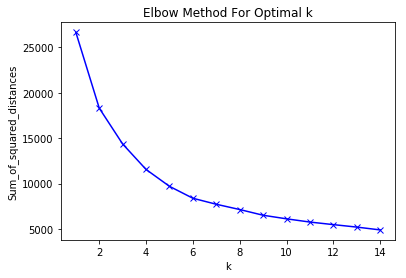

In [34]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

No clear elbow, will choose k=6

In [35]:
# Define the features; choosing all of dataset
X = df_boston

In [36]:
from sklearn.cluster import KMeans
Kmean = KMeans(n_clusters=6, random_state=42)
# Normalize the data.
X_norm = normalize(X)
Kmean.fit(X_norm)

# Calculate predicted values.
y_pred = Kmean.fit_predict(X_norm)

In [37]:
print(y_pred)

[4 4 4 ... 1 1 3]


In [38]:
#finding the centroid
Kmean.cluster_centers_

array([[ 7.84020925e-03,  8.58234268e-02,  1.97693812e-02,
         8.60205023e-03,  3.46142822e-02,  6.41054127e-01,
         2.83111458e-02,  7.54014213e-01,  1.32174670e-03,
         2.39624072e-02,  3.92522857e-03,  1.66174608e-02,
         1.57650755e-02,  3.26769371e-02,  2.12713983e-03,
         1.85372752e-04,  1.26117737e-06,  9.12747044e-07,
         1.86122397e-05,  2.49709872e-07,  1.01022797e-06,
         3.90274642e-07,  1.16887362e-06,  1.23378282e-06,
         3.92227404e-06,  1.22273852e-06,  9.13324263e-07,
         1.52563189e-06,  2.33281611e-06,  1.25962263e-06,
         1.65208537e-07,  1.85482700e-06,  9.06575027e-07,
         7.38394346e-07,  1.79425382e-06,  1.39333047e-04,
         4.56500520e-06],
       [ 2.54038713e-03,  1.07131208e-01,  6.71666214e-03,
         1.87609052e-03,  1.18515260e-02,  3.66184579e-01,
         9.66013666e-03,  9.20192693e-01,  4.52383926e-04,
         8.09589493e-03,  1.26112676e-03,  5.46949657e-03,
         5.20227976e-03,  1.12

In [39]:
df_boston['k_means_predictions'] = y_pred
df_boston.head()

,10k,division,25k,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k,pace_km,gender_M,AUS,BRA,CAN,CHN,COL,DEN,ESP,FRA,GBR,GER,HKG,IRL,ITA,JPN,KOR,MEX,NED,SUI,SWE,USA,other,k_means_predictions
0,17.370001,8,47.669998,47,85.25,8,71.400002,8,3.27,59.180000,8.020000,39.720001,37.650002,80.430000,5.262542,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,4
1,32.580002,1,82.430000,33,138.95,1,116.370003,21,5.30,99.330002,16.219999,69.470001,65.830002,132.100006,8.529502,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4
2,16.620001,1,45.799999,41,80.60,1,67.419998,1,3.08,56.450001,7.750000,38.029999,36.099998,76.099998,4.956767,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4
3,32.570000,3,82.430000,24,140.58,3,116.370003,27,5.37,99.330002,16.200001,69.470001,65.830002,132.949997,8.642156,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4
4,17.120001,2,46.369999,40,81.23,2,67.830002,2,3.10,57.029999,8.020000,38.599998,36.580002,76.720001,4.988954,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,4


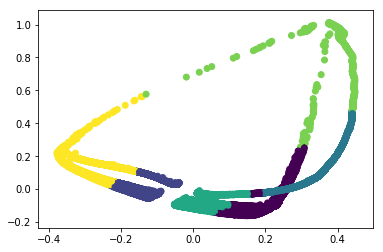

Comparing k-means clusters against the data:
col_0     0      1     2     3    4     5
row_0                                    
0         0  10815     0     0    0     7
1       105      0  2558     0   17     0
2      4552      0   501   326    0     0
3         0     19     0     0    1  3487
4         0      0    65     0  341     0
5       189      0     0  9001    0     0


In [40]:
# Reduce it to two components.
X_pca = PCA(2).fit_transform(X_norm)

# Calculate predicted values.
y_pca_pred = Kmean.fit_predict(X_pca)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pca_pred, y_pred))

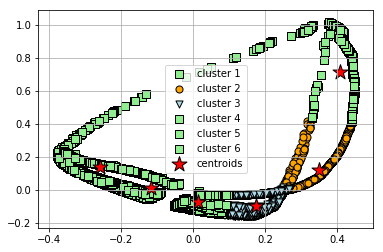

In [41]:
# plot the 6 clusters (X_pca)
plt.scatter(
    X_pca[y_pca_pred == 0, 0], X_pca[y_pca_pred == 0, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    X_pca[y_pca_pred == 1, 0], X_pca[y_pca_pred == 1, 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)

plt.scatter(
    X_pca[y_pca_pred == 2, 0], X_pca[y_pca_pred == 2, 1],
    s=50, c='lightblue',
    marker='v', edgecolor='black',
    label='cluster 3'
)

plt.scatter(
    X_pca[y_pca_pred == 3, 0], X_pca[y_pca_pred == 3, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 4'
)

plt.scatter(
    X_pca[y_pca_pred == 4, 0], X_pca[y_pca_pred == 4, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 5'
)

plt.scatter(
    X_pca[y_pca_pred == 5, 0], X_pca[y_pca_pred == 5, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 6'
)

# plot the centroids
plt.scatter(
    Kmean.cluster_centers_[:, 0], Kmean.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

## data story

In [42]:
df_boston.groupby('k_means_predictions').describe()

10k                                             \
                       count       mean       std        min        25%   
k_means_predictions                                                       
0                     4846.0  44.239246  3.506276  32.119999  42.230000   
1                    10834.0  57.479370  9.850453  41.669998  51.480000   
2                     3124.0  41.209778  3.441587  31.150000  39.330002   
3                     9327.0  55.914379  8.856268  36.869999  49.980000   
4                      359.0  32.864689  5.319328  16.620001  32.580002   
5                     3494.0  46.753914  4.174158  36.470001  45.020000   

                                                      division               \
                           50%        75%         max    count         mean   
k_means_predictions                                                           
0                    44.230000  46.270000  131.644012   4846.0   745.513000   
1                    55.320000  61.700001  261.195892  10834.0  2593.306904   
2                    41.320000  42.730000  128.425339   3124.0  1799.497759   
3                    54.869999  60.320000  239.469788   9327.0  2289.023051   
4                    34.680000  36.210001   38.700001    359.0    83.175487   
5                    46.980000  48.480000  133.253357   3494.0   887.591299   

                                                                           \
                             std    min      25%     50%      75%     max   
k_means_predictions                                                         
0                     677.382260    1.0   281.00   620.0  1023.75  3541.0   
1                    2047.337720    1.0   863.25  1904.0  4270.75  6979.0   
2                     901.969329  234.0  1018.75  1799.5  2580.25  3361.0   
3                    1611.046758    1.0  1085.00  1910.0  3579.50  5911.0   
4                      75.114176    1.0    15.50    58.0   147.50   240.0   
5                     732.376118    1.0   239.00   641.5  1514.75  2388.0   

                         25k                                                 \
                       count        mean        std         min         25%   
k_means_predictions                                                           
0                     4846.0  111.832916   8.586471   82.230003  106.720001   
1                    10834.0  154.473633  54.510693  106.879997  132.250000   
2                     3124.0  103.835869   8.348968   83.620003   99.199997   
3                     9327.0  148.962189  46.802856   70.000000  128.529999   
4                      359.0   83.566223  11.933113   45.799999   83.329998   
5                     3494.0  118.008255   8.162110   92.050003  114.204998   

                                                             age             \
                            50%         75%         max    count       mean   
k_means_predictions                                                           
0                    112.099998  116.895000  323.879669   4846.0  47.195832   
1                    142.869995  162.109997  696.039551  10834.0  41.216448   
2                    104.040001  107.449997  317.844635   3124.0  31.848592   
3                    140.929993  158.489998  710.925964   9327.0  47.840570   
4                     87.699997   90.975002  101.080002    359.0  31.874652   
5                    118.975002  122.427500  319.051666   3494.0  35.475386   

                                                             official  \
                           std   min   25%   50%   75%   max    count   
k_means_predictions                                                     
0                     6.251376  18.0  43.0  47.0  51.0  73.0   4846.0   
1                    10.787395  18.0  32.0  42.0  49.0  81.0  10834.0   
2                     5.002381  18.0  28.0  32.0  36.0  39.0   3124.0   
3                    12.059275  18.0  39.0  49.0  57.0  81.0   9327.0   
4       

In [45]:
time_markers = ['5k', '10k', '20k', 'half', '25k', '30k', '35k', '40k', 'official','k_means_predictions']

In [46]:
df_boston[time_markers].groupby('k_means_predictions').describe()

5k                                             \
                       count       mean       std        min        25%   
k_means_predictions                                                       
0                     4846.0  22.125439  1.747705  15.680000  21.120001   
1                    10834.0  28.472095  4.759986  20.320000  25.670000   
2                     3124.0  20.669781  1.877397  15.200000  19.715000   
3                     9327.0  27.753866  4.165551  17.900000  24.870001   
4                      359.0  16.307325  2.863581   7.750000  16.200001   
5                     3494.0  23.358000  1.940832  18.200001  22.480000   

                                                           10k             \
                           50%        75%         max    count       mean   
k_means_predictions                                                         
0                    22.100000  23.120001   62.925194   4846.0  44.239246   
1                    27.480000  30.549999  130.597946  10834.0  57.479370   
2                    20.730000  21.430000   62.764259   3124.0  41.209778   
3                    27.330000  30.020000   94.307327   9327.0  55.914379   
4                    17.219999  18.075000   19.629999    359.0  32.864689   
5                    23.469999  24.219999   64.373596   3494.0  46.753914   

                                                                           \
                          std        min        25%        50%        75%   
k_means_predictions                                                         
0                    3.506276  32.119999  42.230000  44.230000  46.270000   
1                    9.850453  41.669998  51.480000  55.320000  61.700001   
2                    3.441587  31.150000  39.330002  41.320000  42.730000   
3                    8.856268  36.869999  49.980000  54.869999  60.320000   
4                    5.319328  16.620001  32.580002  34.680000  36.210001   
5                    4.174158  36.470001  45.020000  46.980000  48.480000   

                                     20k                                    \
                            max    count        mean        std        min   
k_means_predictions                                                          
0                    131.644012   4846.0   89.077286   7.251488  65.150002   
1                    261.195892  10834.0  118.286911  22.434036  83.400002   
2                    128.425339   3124.0   82.686134   5.944566  65.669998   
3                    239.469788   9327.0  114.770279  20.870583  75.080002   
4                     38.700001    359.0   66.640221   9.720346  36.099998   
5                    133.253357   3494.0   94.075462   7.661125  73.300003   

                                                                        half  \
                            25%         50%         75%         max    count   
k_means_predictions                                                            
0                     85.000000   89.174999   93.070000  259.103729   4846.0   
1                    104.650002  112.709999  127.000000  522.391785  10834.0   
2                     79.050003   82.924999   85.622501  251.057037   3124.0   
3                    101.580002  111.250000  123.959999  568.740784   9327.0   
4                     65.924999   69.919998   72.699997   78.820000    359.0   
5                     90.820000   94.699997   97.477503  257.494385   3494.0   

                                                                               \
                           mean        std        min         25%         50%   
k_means_predictions                                                             
0                     93.856407   5.895212  68.730003   89.672499   94.110001   
1                    124.273605  18.300365  88.029999  110.519997  118.930000   
2                     87.180458   5.402952  69.550003   83.414999   87.500000   
3                    120.923004  18.208731  79.43000

In [51]:
begin = df_boston.groupby('k_means_predictions', as_index=False)['5k'].mean()
middle = df_boston.groupby('k_means_predictions', as_index=False)['half'].mean()
end = df_boston.groupby('k_means_predictions', as_index=False)['official'].mean()

,k_means_predictions,5k
0,0,22.125444
1,1,28.472059
2,2,20.669775
3,3,27.753841
4,4,16.307325
5,5,23.358009


In [60]:
distance = pd.merge(begin, middle, how='inner', on = 'k_means_predictions')
distance = pd.merge(distance, end, how='inner', on = 'k_means_predictions')
distance

,k_means_predictions,5k,half,official
0,0,22.125444,93.856407,197.482658
1,1,28.472059,124.273636,271.178516
2,2,20.669775,87.180527,183.601060
3,3,27.753841,120.923164,271.641477
4,4,16.307325,70.287323,145.034290
5,5,23.358009,99.024956,205.449347


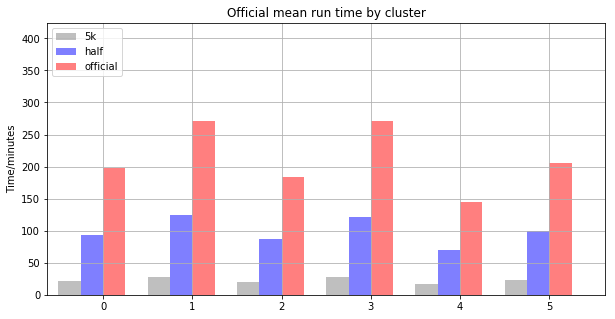

In [76]:
#cluster = distance['k_means_predictions']

# Setting the positions and width for the bars
pos = list(range(len(distance['official']))) 
width = 0.25 
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(10,5))

# Create a bar with 5k data,
# in position pos,
plt.bar(pos, 
        #using df['5k'] data,
        distance['5k'], 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='gray', 
        # with label the first value in first_name
        label=distance['k_means_predictions'][0]) 

# Create a bar with half data,
# in position pos + some width buffer,
plt.bar([p + width for p in pos], 
        #using df['half'] data,
        distance['half'],
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='blue', 
        # with label the second value in first_name
        label=distance['k_means_predictions'][1]) 

# Create a bar with official data,
# in position pos + some width buffer,
plt.bar([p + width*2 for p in pos], 
        #using df['official'] data,
        distance['official'], 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='red', 
        # with label the third value in first_name
        label=distance['k_means_predictions'][2]) 

# Set the y axis label
ax.set_ylabel('Time/minutes')

# Set the chart's title
ax.set_title('Official mean run time by cluster')

# Set the position of the x ticks
ax.set_xticks([p + 1.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(distance['k_means_predictions'])

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, max(distance['5k'] + distance['half'] + distance['official'])] )

# Adding the legend and showing the plot
plt.legend(['5k', 'half', 'official'], loc='upper left')
plt.grid()
plt.show()

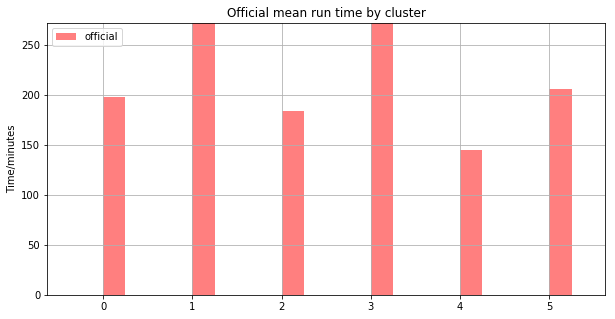

In [77]:
#cluster = distance['k_means_predictions']

# Setting the positions and width for the bars
pos = list(range(len(distance['official']))) 
width = 0.25 
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(10,5))


# Create a bar with official data,
# in position pos + some width buffer,
plt.bar([p + width*2 for p in pos], 
        #using df['official'] data,
        distance['official'], 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='red', 
        # with label the third value in first_name
        label=distance['k_means_predictions'][2]) 

# Set the y axis label
ax.set_ylabel('Time/minutes')

# Set the chart's title
ax.set_title('Official mean run time by cluster')

# Set the position of the x ticks
ax.set_xticks([p + 1.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(distance['k_means_predictions'])

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, max(distance['official'])] )

# Adding the legend and showing the plot
plt.legend(['official'], loc='upper left')
plt.grid()
plt.show()

In [47]:
df_boston.columns

Index(['10k', 'division', '25k', 'age', 'official', 'genderdiv', '35k',
       'overall', 'pace', '30k', '5k', 'half', '20k', '40k', 'pace_km',
       'gender_M', 'AUS', 'BRA', 'CAN', 'CHN', 'COL', 'DEN', 'ESP', 'FRA',
       'GBR', 'GER', 'HKG', 'IRL', 'ITA', 'JPN', 'KOR', 'MEX', 'NED', 'SUI',
       'SWE', 'USA', 'other', 'k_means_predictions'],
      dtype='object')

In [88]:
characteristics = ['age', 'gender_M', 'overall', 
                   'pace', 'k_means_predictions']

In [89]:
df_boston[characteristics].groupby('k_means_predictions').describe()

age                                                \
                       count       mean        std   min   25%   50%   75%   
k_means_predictions                                                          
0                     4846.0  47.195832   6.251376  18.0  43.0  47.0  51.0   
1                    10834.0  41.216448  10.787395  18.0  32.0  42.0  49.0   
2                     3124.0  31.848592   5.002381  18.0  28.0  32.0  36.0   
3                     9327.0  47.840570  12.059275  18.0  39.0  49.0  57.0   
4                      359.0  31.874652   7.113085  18.0  27.0  30.0  35.5   
5                     3494.0  35.475386   8.212037  18.0  29.0  35.0  41.0   

                          gender_M                                          \
                      max    count      mean       std  min  25%  50%  75%   
k_means_predictions                                                          
0                    73.0   4846.0  1.000000  0.000000  1.0  1.0  1.0  1.0   
1                    81.0  10834.0  0.000000  0.000000  0.0  0.0  0.0  0.0   
2                    39.0   3124.0  1.000000  0.000000  1.0  1.0  1.0  1.0   
3                    81.0   9327.0  1.000000  0.000000  1.0  1.0  1.0  1.0   
4                    59.0    359.0  0.891365  0.311615  0.0  1.0  1.0  1.0   
5                    65.0   3494.0  0.000000  0.000000  0.0  0.0  0.0  0.0   

                          overall                                      \
                     max    count          mean          std      min   
k_means_predictions                                                     
0                    1.0   4846.0   6250.180561  3002.194818    360.0   
1                    0.0  10834.0  21836.848440  5734.766573  11928.0   
2                    1.0   3124.0   3320.917414  2359.307605    296.0   
3                    1.0   9327.0  21858.312534  5933.520558  11129.0   
4                    1.0    359.0    135.381616    94.584666      1.0   
5                    0.0   3494.0   8199.014596  2722.088171    443.0   

                                                              pace             \
                          25%      50%       75%      max    count       mean   
k_means_predictions                                                             
0                     3825.25   6237.5   8861.75  11455.0   4846.0   7.540340   
1                    16848.25  21644.5  26775.75  31927.0  10834.0  10.350533   
2                     1391.75   2733.5   4786.25   9407.0   3124.0   7.010957   
3                    16766.00  22076.0  27004.00  31931.0   9327.0  10.367320   
4                       45.50    127.0    216.50    401.0    359.0   5.539666   
5                     6392.50   8589.0  10457.00  12369.0   3494.0   7.844170   

                                                                
                          std   min   25%    50%    75%    max  
k_means_predictions                                             
0                    0.497890  6.13  7.20  7.600   7.97   8.28  
1                    1.689764  8.33  8.98  9.875  11.28  17.62  
2                    0.486603  6.07  6.65  6.970   7.37   8.03  
3                    1.698397  8.25  8.98  9.970  11.37  20.57  
4                    0.760254  3.08  5.48  5.830   5.98   7.30  
5                    0.405336  6.20  7.63  7.930   8.17   8.38

In [78]:
cluster_1 = df_boston['k_means_predictions']==0

In [80]:
cluster_2 = df_boston['k_means_predictions']==1

In [83]:
cluster_3 = df_boston['k_means_predictions']==2

In [84]:
cluster_4 = df_boston['k_means_predictions']==3

In [85]:
cluster_5 = df_boston['k_means_predictions']==4

In [86]:
cluster_6 = df_boston['k_means_predictions']==5

In [92]:
#fastest cluster
df_boston[characteristics].groupby(cluster_5).describe()

age                                                \
                       count       mean        std   min   25%   50%   75%   
k_means_predictions                                                          
False                31625.0  42.526640  11.299137  18.0  34.0  43.0  50.0   
True                   359.0  31.874652   7.113085  18.0  27.0  30.0  35.5   

                          gender_M                                          \
                      max    count      mean       std  min  25%  50%  75%   
k_means_predictions                                                          
False                81.0  31625.0  0.546941  0.497800  0.0  0.0  1.0  1.0   
True                 59.0    359.0  0.891365  0.311615  0.0  1.0  1.0  1.0   

                          overall                                            \
                     max    count          mean          std    min     25%   
k_means_predictions                                                           
False                1.0  31625.0  16118.993676  9129.506402  296.0  8213.0   
True                 1.0    359.0    135.381616    94.584666    1.0    45.5   

                                                   pace                      \
                         50%      75%      max    count      mean       std   
k_means_predictions                                                           
False                16119.0  24025.0  31931.0  31625.0  9.318068  1.961703   
True                   127.0    216.5    401.0    359.0  5.539666  0.760254   

                                                    k_means_predictions  \
                      min   25%   50%    75%    max               count   
k_means_predictions                                                       
False                6.07  7.88  8.90  10.45  20.57             31625.0   
True                 3.08  5.48  5.83   5.98   7.30               359.0   

                                                                  
                         mean       std  min  25%  50%  75%  max  
k_means_predictions                                               
False                1.977328  1.498109  0.0  1.0  2.0  3.0  5.0  
True                 4.000000  0.000000  4.0  4.0  4.0  4.0  4.0

In [94]:
df_boston['official'].groupby(cluster_5).describe()

,count,mean,std,min,25%,50%,75%,max
k_means_predictions,,,,,,,,
False,31625.0,244.109369,51.494747,158.98,206.50,233.12,273.900,538.88
True,359.0,145.034290,19.932230,80.60,143.45,152.82,156.755,191.33


In [96]:
countries = ['AUS', 'BRA', 'CAN', 'CHN', 'COL', 'DEN', 'ESP', 'FRA',
       'GBR', 'GER', 'HKG', 'IRL', 'ITA', 'JPN', 'KOR', 'MEX', 'NED', 'SUI',
       'SWE', 'USA', 'k_means_predictions']

In [97]:
df_boston[countries].groupby(cluster_5).describe()

AUS                                               \
                       count      mean       std  min  25%  50%  75%  max   
k_means_predictions                                                         
False                31625.0  0.003858  0.061992  0.0  0.0  0.0  0.0  1.0   
True                   359.0  0.005571  0.074535  0.0  0.0  0.0  0.0  1.0   

                         BRA                                               \
                       count      mean       std  min  25%  50%  75%  max   
k_means_predictions                                                         
False                31625.0  0.002688  0.051775  0.0  0.0  0.0  0.0  1.0   
True                   359.0  0.005571  0.074535  0.0  0.0  0.0  0.0  1.0   

                         CAN                                               \
                       count      mean       std  min  25%  50%  75%  max   
k_means_predictions                                                         
False                31625.0  0.068111  0.251940  0.0  0.0  0.0  0.0  1.0   
True                   359.0  0.058496  0.235006  0.0  0.0  0.0  0.0  1.0   

                         CHN                                               \
                       count      mean       std  min  25%  50%  75%  max   
k_means_predictions                                                         
False                31625.0  0.001202  0.034644  0.0  0.0  0.0  0.0  1.0   
True                   359.0  0.011142  0.105113  0.0  0.0  0.0  0.0  1.0   

                         COL                                               \
                       count      mean       std  min  25%  50%  75%  max   
k_means_predictions                                                         
False                31625.0  0.001233  0.035096  0.0  0.0  0.0  0.0  1.0   
True                   359.0  0.002786  0.052778  0.0  0.0  0.0  0.0  1.0   

                         DEN                                               \
                       count      mean       std  min  25%  50%  75%  max   
k_means_predictions                                                         
False                31625.0  0.001581  0.039731  0.0  0.0  0.0  0.0  1.0   
True                   359.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   

                         ESP                                               \
                       count      mean       std  min  25%  50%  75%  max   
k_means_predictions                                                         
False                31625.0  0.002656  0.051470  0.0  0.0  0.0  0.0  1.0   
True                   359.0  0.013928  0.117354  0.0  0.0  0.0  0.0  1.0   

                         FRA                                               \
                       count      mean       std  min  25%  50%  75%  max   
k_means_predictions                                                         
False                31625.0  0.003573  0.059670  0.0  0.0  0.0  0.0  1.0   
True                   359.0  0.005571  0.074535  0.0  0.0  0.0  0.0  1.0   

                         GBR                                               \
                       count      mean       std  min  25%  50%  75%  max   
k_means_predictions                                                         
False                31625.0  0.010877  0.103728  0.0  0.0  0.0  0.0  1.0   
True                   359.0  0.005571  0.074535  0.0  0.0  0.0  0.0  1.0   

                         GER                                               \
                       count      mean       std  min  25%  50%  75%  max   
k_means_predictions                                                         
False                31625.0  0.005723  0.075437  0.0  0.0  0.0  0.0  1.0   
True                   359.0  0.002786  0.052778  0.0  0.0  0.0  0.0  1.0   

                         HKG                                               \
                       count      mean       std  min  25%  50%  75%  max   
k_means_pre

In [99]:
df_boston[countries].groupby('k_means_predictions').count()

,AUS,BRA,CAN,CHN,COL,DEN,ESP,FRA,GBR,GER,HKG,IRL,ITA,JPN,KOR,MEX,NED,SUI,SWE,USA
k_means_predictions,,,,,,,,,,,,,,,,,,,,
0,4846,4846,4846,4846,4846,4846,4846,4846,4846,4846,4846,4846,4846,4846,4846,4846,4846,4846,4846,4846
1,10834,10834,10834,10834,10834,10834,10834,10834,10834,10834,10834,10834,10834,10834,10834,10834,10834,10834,10834,10834
2,3124,3124,3124,3124,3124,3124,3124,3124,3124,3124,3124,3124,3124,3124,3124,3124,3124,3124,3124,3124
3,9327,9327,9327,9327,9327,9327,9327,9327,9327,9327,9327,9327,9327,9327,9327,9327,9327,9327,9327,9327
4,359,359,359,359,359,359,359,359,359,359,359,359,359,359,359,359,359,359,359,359
5,3494,3494,3494,3494,3494,3494,3494,3494,3494,3494,3494,3494,3494,3494,3494,3494,3494,3494,3494,3494


In [100]:
distance

,k_means_predictions,5k,half,official
0,0,22.125444,93.856407,197.482658
1,1,28.472059,124.273636,271.178516
2,2,20.669775,87.180527,183.601060
3,3,27.753841,120.923164,271.641477
4,4,16.307325,70.287323,145.034290
5,5,23.358009,99.024956,205.449347


In [101]:
cluster_age = df_boston.groupby('k_means_predictions', as_index=False)['age'].mean()

In [102]:
distance = pd.merge(distance, cluster_age, how='inner', on = 'k_means_predictions')

In [103]:
cluster_gender = df_boston.groupby('k_means_predictions', as_index=False)['gender_M'].mean()

In [104]:
distance = pd.merge(distance, cluster_gender, how='inner', on = 'k_means_predictions')

In [105]:
distance

,k_means_predictions,5k,half,official,age,gender_M
0,0,22.125444,93.856407,197.482658,47.195832,1.000000
1,1,28.472059,124.273636,271.178516,41.216448,0.000000
2,2,20.669775,87.180527,183.601060,31.848592,1.000000
3,3,27.753841,120.923164,271.641477,47.840570,1.000000
4,4,16.307325,70.287323,145.034290,31.874652,0.891365
5,5,23.358009,99.024956,205.449347,35.475386,0.000000


Cluster 5 is the "fastest" cluster of the dataset. This cluster contains 359 runners who ran an average pace of 5.54 minutes/mile with an average finish time of 145 minutes. The average age of the cluster is 31.87 years (maximum age 59 yrs) and is overwhelmingly male (89%). Most of the runners in the group are from the USA (76.9%), with the rest from various nations including CAN (5.8%), ESP (1.4%), CHN (1.1%), and AUS, BRA, SUI, ITA, GBR, FRA, COL, GER, JPN, Other (less than 1%). 

The other clusters, from fastest to slowest are as follows: 
Cluster 3: finish time 183.6 minutes, average age 31.8, all male;
Cluster 1: finish time 197.5 minutes, average age 47.2, all male;
Cluster 6: finish time 205.4 minutes, average age 35.5, all female;
Cluster 2: finish time 271.2 minutes, average age 41.2, all female; 
Cluster 4: finish time 271.6 minutes, average age 47.8, all male.

From these groups we can see that in general, a lower average age runs faster than a higher average age BY GENDER, males run faster than females despite age. 

## other clusters
unable to run at this time due to memory constraints on computer. 

In [ ]:
#fit MeanShift with X_norm
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_norm, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_norm)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

In [ ]:
plt.scatter(X_norm[:, 0], X_norm[:, 1], c=labels)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_pred,labels))

In [ ]:
from sklearn.model_selection import train_test_split

#divide data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X_norm,
    y_pred,
    test_size=0.9,
    random_state=42)

In [ ]:
#fit MeanShift with test/train
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_train, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))


In [ ]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=labels)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train,labels))

In [ ]:
#fit SpectralClustering with X_norm
from sklearn.cluster import SpectralClustering

# looking for 6 clusters.
n_clusters=6

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters)
sc.fit(X_norm)

#Predicted clusters.
predict=sc.fit_predict(X_norm)

#Graph results.
plt.scatter(X_norm[:, 0], X_norm[:, 1], c=predict)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_pred,predict))

In [ ]:
#fit SpectralClustering with test/train
from sklearn.cluster import SpectralClustering

# looking for 6 clusters.
n_clusters=6

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters)
sc.fit(X_train)

#Predicted clusters.
predict=sc.fit_predict(X_train)

#Graph results.
plt.scatter(X_train[:, 0], X_train[:, 1], c=predict)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train,predict))

In [ ]:
#fit AffinityPropagation with X_norm
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

# Declare the model and fit 
af = AffinityPropagation().fit(X_norm)
print('Done')

# Pull the number of clusters and cluster assignments for each data point.
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

print('Estimated number of clusters: {}'.format(n_clusters_))

In [ ]:
from itertools import cycle

plt.figure(1)
plt.clf()

# Cycle through each cluster and graph them with a center point for the
# exemplar and lines from the exemplar to each data point in the cluster.
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X_norm[cluster_centers_indices[k]]
    plt.plot(X_norm[class_members, 0], X_norm[class_members, 1], col + '.')
    plt.plot(cluster_center[0],
             cluster_center[1],
             'o',
             markerfacecolor=col,
             markeredgecolor='k')
    for x in X_norm[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: {}'.format(n_clusters_))
plt.show()

In [ ]:
#fit AffinityPropagation with test/train
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

# Declare the model and fit 
af = AffinityPropagation().fit(X_train)
print('Done')

# Pull the number of clusters and cluster assignments for each data point.
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

print('Estimated number of clusters: {}'.format(n_clusters_))

In [ ]:
from itertools import cycle

plt.figure(1)
plt.clf()

# Cycle through each cluster and graph them with a center point for the
# exemplar and lines from the exemplar to each data point in the cluster.
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X_train[cluster_centers_indices[k]]
    plt.plot(X_train[class_members, 0], X_train[class_members, 1], col + '.')
    plt.plot(cluster_center[0],
             cluster_center[1],
             'o',
             markerfacecolor=col,
             markeredgecolor='k')
    for x in X_train[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: {}'.format(n_clusters_))
plt.show()

## evaluation

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA


# Make sure the number of rows divides evenly into four samples.
rows = df_boston.shape[0] - df_boston.shape[0] % 4
df_eval = df_boston.iloc[:rows, :]

# Break into a set of features and a variable for the known outcome.
X = df_eval.loc[:, df_eval.columns != 'overall']
y = df_eval['overall']

# Normalize
X_norm = normalize(X)

# Data frame to store features and predicted cluster memberships.
ypred = pd.DataFrame()

# Create the two-feature PCA for graphing purposes.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)

# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_norm,
    X_pca,
    test_size=0.5,
    random_state=42)

# Then we halve the halves.
X1, X2, X_pca1, X_pca2 = train_test_split(
    X_half1,
    X_pcahalf1,
    test_size=0.5,
    random_state=42)
X3, X4, X_pca3, X_pca4 = train_test_split(
    X_half2,
    X_pcahalf2,
    test_size=0.5,
    random_state=42)

# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by k-means,
# and the PCA-derived features for graphing. We use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# PCA solution in the data frame.
for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2, 7):
        pred = KMeans(n_clusters=nclust, random_state=42).fit_predict(data[0])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

In [ ]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 7):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(3, 2)
    
    # Make a plot for each sample.
    for i in range(5):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        rows = int(np.floor(i / 2))
        cols = i % 2
        axarr[rows, cols].scatter(x_sub, y_sub, c=c)
        axarr[rows, cols].set_title('sample {}'.format(i))
        axarr[rows, cols].set_xlim([-.3, .3])
        axarr[rows, cols].set_ylim([-.3, .3])
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

In [ ]:
# Get predicted clusters.
full_pred = KMeans(n_clusters=6, random_state=42).fit_predict(X_norm)

pd.crosstab(y, full_pred) 


import itertools

# Create a list of pairs, where each pair is the ground truth group
# and the assigned cluster.
c = list(itertools.product(y, full_pred))

# Count how often each type of pair (a, b, c, or d) appears.
RIcounts = [[x, c.count(x)] for x in set(c)]
print(RIcounts)

# Create the same counts but without the label, for easier math below.
RIcounts_nolabel = [c.count(x) for x in set(c)]

# Calculate the Rand Index.
RIscore = (RIcounts_nolabel[3] + RIcounts_nolabel[2]) / np.sum(RIcounts_nolabel)
print(RIscore)

In [ ]:
from sklearn import metrics
    
metrics.adjusted_rand_score(y, full_pred)

In [ ]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances

for sample in [X1, X2, X3, X4]:
    model = KMeans(n_clusters=2, random_state=42).fit(sample)
    labels = model.labels_
    print(metrics.silhouette_score(sample, labels, metric='euclidean'))